# Lab Network Expansion - EDA and Solution

## Imports

In [1]:
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import numpy as np
import momepy
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import math
import sklearn
import pgeocode
import utm
import random

random.seed(9678)
np.random.seed(42)

/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


## Loading data

In [2]:
df_geocode = pd.read_csv('data/df_geocode.csv', delimiter=';')
df_testdata = pd.read_csv('data/test_data.csv', delimiter=';')
df_trans_data = pd.read_csv('data/transactional_data.csv', delimiter=';')
df_dem_data = pd.read_csv('data/demographic_data/ACSDP5Y2019.DP05_data_with_overlays_2021-07-22T145324.csv')
df_eco_data = pd.read_csv('data/economic_data/eco_formatted_data.csv')
df_eco_data.reset_index(drop=True, inplace=True)
df_eco_data.drop(columns=['Unnamed: 0'], inplace=True)
df_eco_data = df_eco_data.applymap(lambda x: x.replace('"', ''))
df_eco_metadata = pd.read_csv('data/economic_data/ACSDP5Y2019.DP03_metadata_2021-07-23T054157.csv')
df_health_data = pd.read_csv('data/health_insurance_data/ACSST5Y2019.S2701_data_with_overlays_2021-08-26T103547.csv')

/tmp/ipykernel_15508/2913907820.py:4: DtypeWarning: Columns (2,3,4,6,7,10,11,18,19,22,23,26,27,30,31,34,35,38,39,42,43,46,47,50,51,54,55,58,59,62,63,66,67,74,75,78,79,82,83,86,87,90,91,94,95,98,99,100,102,103,106,107,114,115,116,118,119,122,123,130,131,132,134,135,138,139,142,143,146,147,150,151,154,155,158,159,162,163,166,167,170,171,174,175,178,179,182,183,186,187,190,191,194,195,198,199,202,203,206,207,210,211,214,215,218,219,222,223,226,227,230,231,234,235,238,239,242,243,246,247,250,251,252,254,255,258,259,262,263,266,267,270,271,274,275,278,279,280,282,283,286,287,290,291,294,295,298,299,302,303,306,307,310,311,314,315,318,319,322,323,326,327,330,331,334,335,338,339,342,343,346,347,348,350,351,354,355) have mixed types. Specify dtype option on import or set low_memory=False.
  df_dem_data = pd.read_csv('data/demographic_data/ACSDP5Y2019.DP05_data_with_overlays_2021-07-22T145324.csv')
/tmp/ipykernel_15508/2913907820.py:10: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,1

# EDA Geometric Data 

## Current Labs Location Plot in the USA map

In [3]:
df_locs = pd.DataFrame()
latitude, longitude = [], []

df_geocode = df_geocode[df_geocode['location'] != 'Unavailable']
for _,row in df_geocode.iterrows():
    tmp = row['location'].split(',')
    latitude.append(float(tmp[0]))
    longitude.append(float(tmp[1]))
    

df_geocode['latitude'] = latitude
df_geocode['longitude'] = longitude

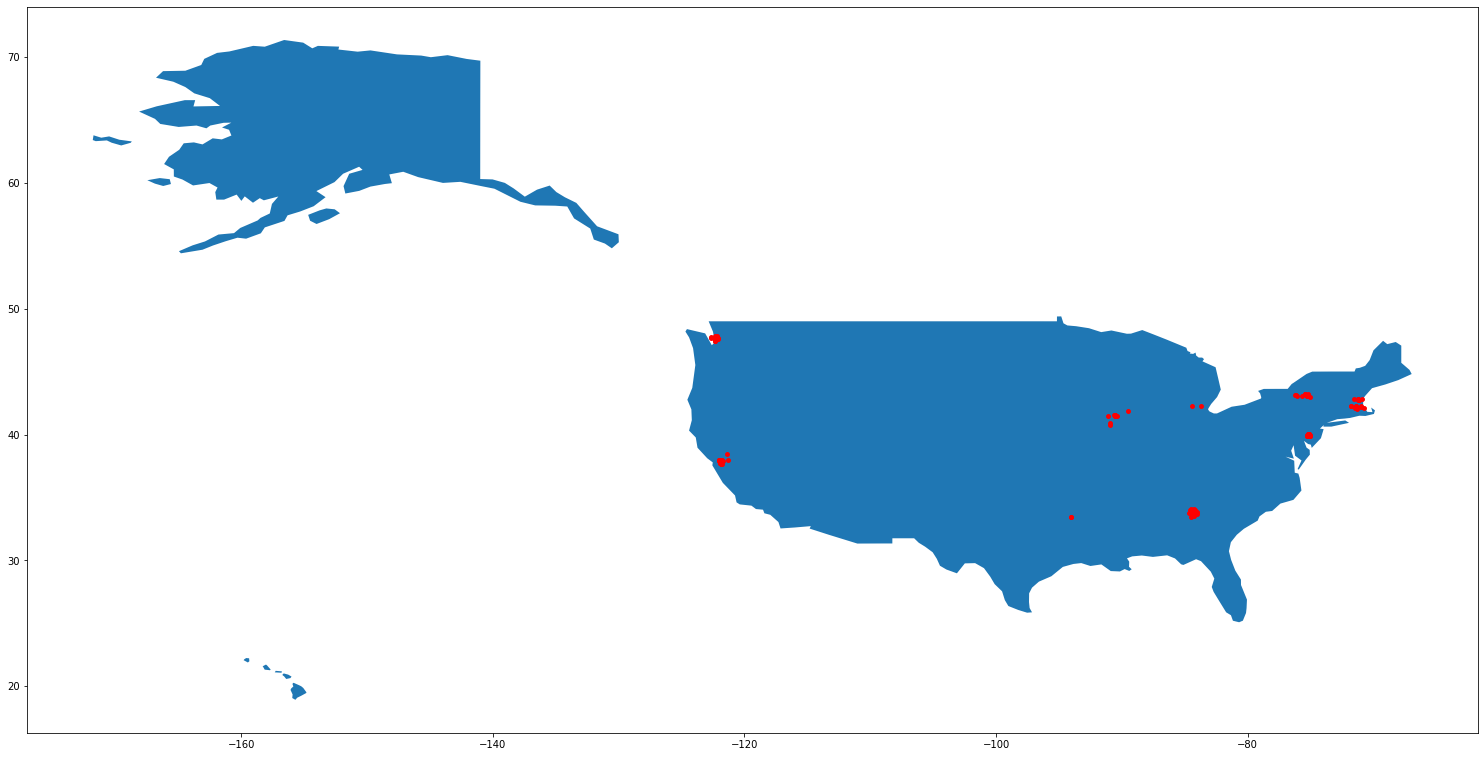

In [4]:
geometry = [Point(xy) for xy in zip(longitude, latitude)]
gdf = GeoDataFrame(df_geocode, geometry=geometry)   

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
usa = world[world.name == "United States of America"]

gdf.plot(ax=usa.plot(figsize=(26, 18)), marker='o', color='red', markersize=15);

In [5]:
zip_to_zcta = pd.read_excel('data/ZiptoZcta_Crosswalk_2021.xlsx')

In [6]:
zip_to_zcta = zip_to_zcta[['ZIP_CODE', 'ZCTA']]

### Get State and ZCTA of each Lab for further analysis

In [7]:
states = []
zctas = []
for _, row in df_geocode.iterrows():
    address = row['Address']
    zipcode = row['zipcode']
    state = address.split(',')[2][1:3]
    zcta = int(zip_to_zcta[zip_to_zcta['ZIP_CODE'] == zipcode]['ZCTA'])
    states.append(state)
    zctas.append(zcta)
    
df_geocode['state'] = states
df_geocode['zcta'] = zctas

In [8]:
%matplotlib inline

<AxesSubplot:title={'center':'Labs installations per state by %'}, ylabel='None'>

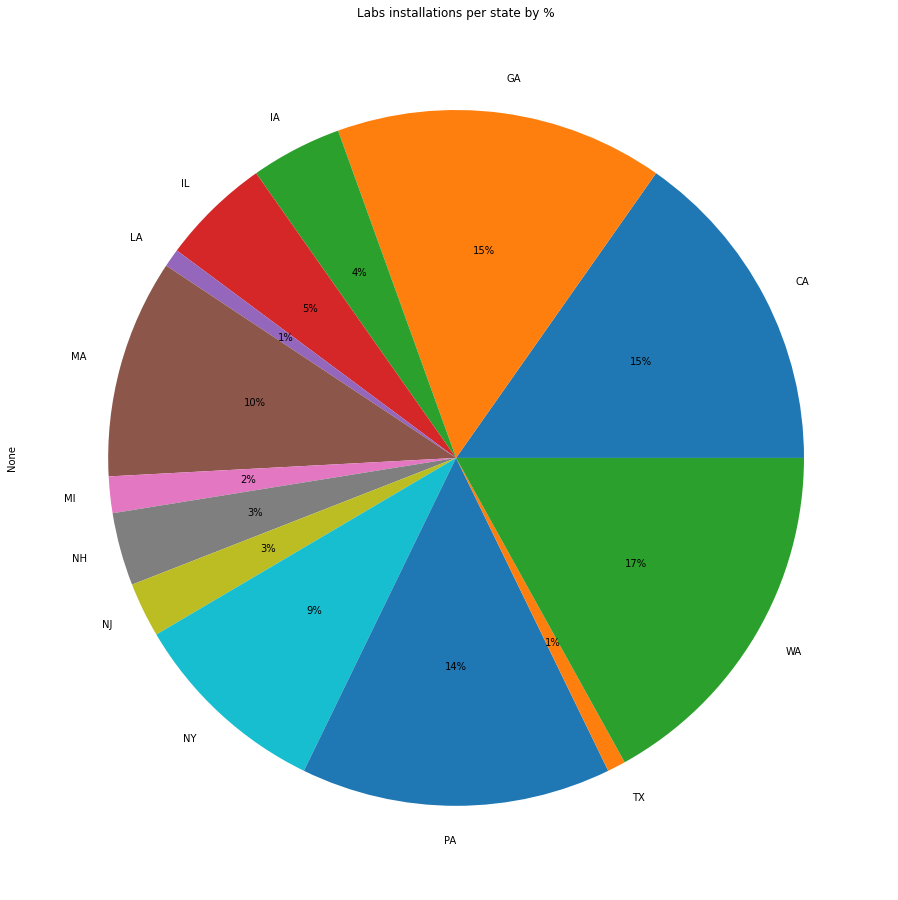

In [9]:
df_geocode.groupby(['state']).size().plot(kind='pie', figsize=(24,16), autopct='%1.0f%%', title='Labs installations per state by %')

### Get profit estimative by lab

In [10]:
cod_item_cost = dict((cod, float(cost.replace(',', '.'))) for cod, cost in zip(list(df_testdata['CodItem']), list(df_testdata['Testing Cost'])))

In [11]:
df_trans_data['exam_cost'] = df_trans_data['CodItem'].map(cod_item_cost)
df_trans_data['Testing Cost'] = df_trans_data['Testing Cost'].apply(lambda a: float(a.replace(',', '.')))
df_trans_data.fillna(0, inplace=True)
df_trans_data

,Patient Id,Gender,Date of birth,Date of service,Service Id,Lab Id,CodItem,Testing Cost,exam_cost
0,10210830256-BIO003,F,01/08/1976 00:00:00,2019-01-07,571904533475-38,L133,70003237,9.0,1.78
1,10210830256-BIO003,F,01/08/1976 00:00:00,2019-01-07,571904533475-38,L133,70000638,13.0,2.46
2,10210830256-BIO003,F,01/08/1976 00:00:00,2019-01-07,571904533475-38,L133,70001597,49.0,2.11
3,10210830256-BIO003,F,01/08/1976 00:00:00,2019-01-07,571904533475-38,L133,70000103,11.0,0.80
4,10210830256-BIO003,F,01/08/1976 00:00:00,2019-01-07,571904533475-38,L133,70000224,10.0,1.02
...,...,...,...,...,...,...,...,...,...
2355236,7664157546-1,M,06/03/1971 00:00:00,2021-02-12,7664157546-1-1,L697,70004038,10.0,1.37
2355237,7664157546-1,M,06/03/1971 00:00:00,2021-02-12,7664157546-1-1,L697,70004134,10.0,0.95
2355238,7664157546-1,M,06/03/1971 00:00:00,2021-02-12,7664157546-1-1,L697,70003056,9.0,1.12
2355239,7664157546-1,M,06/03/1971 00:00:00,2021-02-12,7664157546-1-1,L697,70004185,13.0,2.39


In [12]:
transaction_profit_per_lab = {}
labs = df_trans_data['Lab Id'].unique()
for lab in labs:
    lab_revenue = sum(list(df_trans_data[df_trans_data['Lab Id'] == lab]['Testing Cost']))
    lab_cost = sum(list(df_trans_data[df_trans_data['Lab Id'] == lab]['exam_cost']))
    lab_profit = lab_revenue - lab_cost
    transaction_profit_per_lab[lab] = lab_profit
    
df_geocode['lab_profit'] = df_geocode['Lab Id'].map(transaction_profit_per_lab)
df_geocode.dropna(inplace=True)

### Most profitable Laboratories per state

In [13]:
df_geocode.groupby(['state'])['lab_profit'].sum()

state
CA    2.190021e+07
GA    1.343486e+07
IA    1.435267e+06
IL    1.583317e+06
LA    1.272462e+04
MA    5.260627e+06
MI    1.439550e+06
NH    8.358339e+05
NJ    7.660784e+05
NY    2.107560e+06
PA    1.730127e+07
TX    2.380497e+05
WA    1.728438e+07
Name: lab_profit, dtype: float64

<AxesSubplot:title={'center':'Profit per State in %'}, ylabel='lab_profit'>

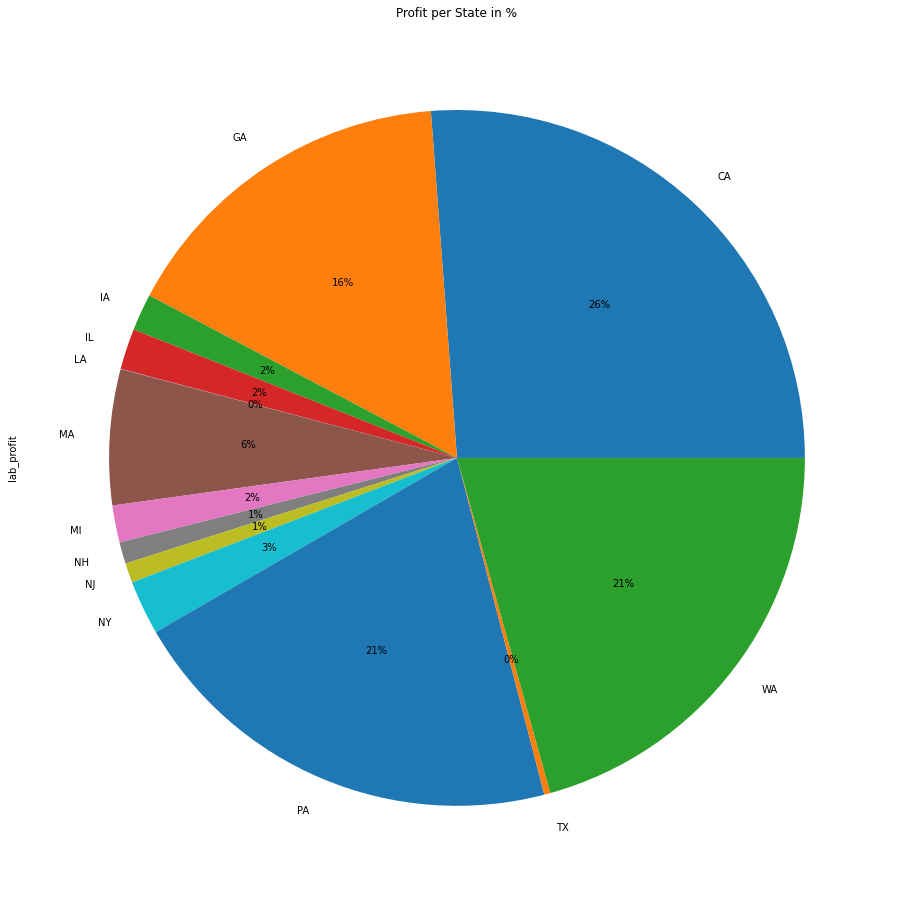

In [14]:
df_geocode.groupby(['state'])['lab_profit'].sum().plot(kind='pie', figsize=(24,16), autopct='%1.0f%%', title='Profit per State in %')

### Crossing data features: Average profit of Laboratory per state

In [15]:
lab_per_state = df_geocode.groupby(['state']).size().to_dict()
profit_per_state = df_geocode.groupby(['state'])['lab_profit'].sum().to_dict()

In [16]:
avg_profit_lab_per_state = {}
for key in lab_per_state.keys():
    avg_profit_lab_per_state[key] = profit_per_state[key]/lab_per_state[key]
avg_profit_lab_per_state

{'CA': 1368763.2674999498,
 'GA': 746381.2944444411,
 'IA': 287053.37000000034,
 'IL': 263886.2033333325,
 'LA': 12724.619999999999,
 'MA': 438385.5941666691,
 'MI': 719775.0649999983,
 'NH': 208958.47250000027,
 'NJ': 255359.45333333345,
 'NY': 191596.32454545403,
 'PA': 1017721.5505882414,
 'TX': 238049.66999999958,
 'WA': 864219.1125000187}

<BarContainer object of 13 artists>

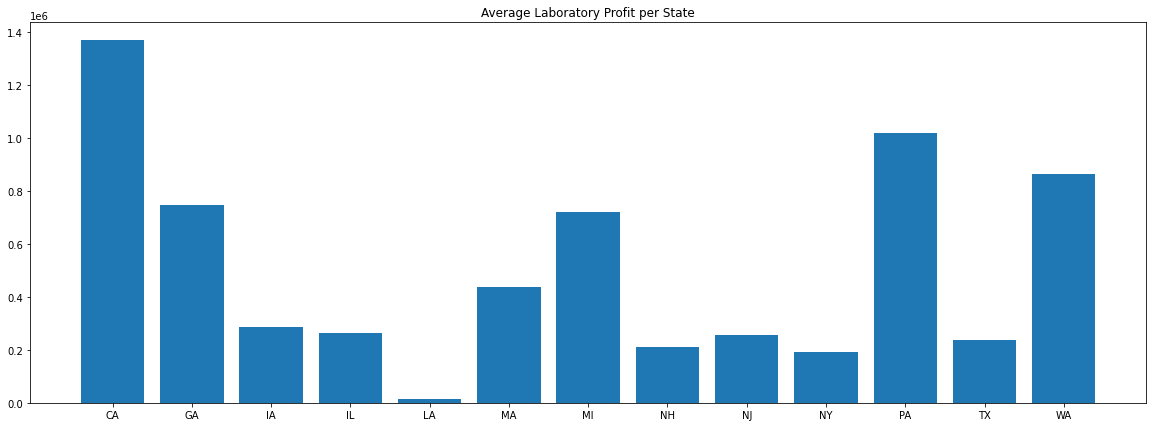

In [17]:
plt.rcParams["figure.figsize"] = (20,7)
plt.title('Average Laboratory Profit per State')
plt.bar(avg_profit_lab_per_state.keys(), avg_profit_lab_per_state.values())

In [18]:
lab_per_state

{'CA': 16,
 'GA': 18,
 'IA': 5,
 'IL': 6,
 'LA': 1,
 'MA': 12,
 'MI': 2,
 'NH': 4,
 'NJ': 3,
 'NY': 11,
 'PA': 17,
 'TX': 1,
 'WA': 20}

In [19]:
df_geocode

,Lab Id,Address,location,zipcode,latitude,longitude,geometry,state,zcta,lab_profit
0,L152,"3800 PLEASANT HILL RD STE 1, DULUTH, GA 30096","34.000319,-84.1629724",30044,34.000319,-84.162972,POINT (-84.16297 34.00032),GA,30044,3748231.85
1,L520,"1614 N JAMES ST, ROME, NY 13440","43.2311327,-75.4445363",13440,43.231133,-75.444536,POINT (-75.44454 43.23113),NY,13440,503512.69
2,L141,"12911 120TH AVE NE STE D60, KIRKLAND, WA 98034","47.7162786,-122.1838152",98034,47.716279,-122.183815,POINT (-122.18382 47.71628),WA,98034,1696331.50
3,L524,"5667 PEACHTREE DUNWOODY RD 250, ATLANTA, GA 30342","33.9093875,-84.3529096",30342,33.909388,-84.352910,POINT (-84.35291 33.90939),GA,30342,323966.32
4,L545,"1204 IL HWY 164, OQUAWKA, IL 61469","40.9309925,-90.9437598",61469,40.930993,-90.943760,POINT (-90.94376 40.93099),IL,61469,78813.21
...,...,...,...,...,...,...,...,...,...,...
114,L886,"1819 MARLTON PIKE W., CHERRY HILL, NJ 08002","39.9184081,-75.035649",8002,39.918408,-75.035649,POINT (-75.03565 39.91841),NJ,8002,346906.21
115,L535,"603 SENECA ST 4, ONEIDA, NY 13421","43.0773695,-75.6536905",13421,43.077370,-75.653690,POINT (-75.65369 43.07737),NY,13421,146830.21
116,L723,"8052 STATE ROUTE 12, BARNEVELD, NY 13304","43.2530101,-75.1860015",13304,43.253010,-75.186002,POINT (-75.18600 43.25301),NY,13304,52991.61
117,L163,"3906 LILLIE AVE STE 3, DAVENPORT, IA 52806","41.5611182,-90.5915183",52806,41.561118,-90.591518,POINT (-90.59152 41.56112),IA,52806,413227.40


### Greatest 5 Average Lab Profit States: CA, PA, WA GA, MI
### The 5 States with the most Labs Installations: WA, GA, PA, CA, MA

# EDA Tabular Data

## Select the variables that describe generally the information of the respective ZCTA

## Economic Data

The following variables were chosen to calculate statistics of the economic active population and economic classes, that may be relevant for installing a laboratory

DP03_0001E - Population 16 years and over Estimative

DP03_0002E - Population 16 years and over In labor force Estimative

"DP03_0004E","Estimate!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force!!Employed"

"DP03_0005E","Estimate!!EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force!!Unemployed"

"DP03_0051E","Estimate!!INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)!!Total households"

"DP03_0052E","Estimate!!INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)!!Total households!!Less than $10,000"

"DP03_0053E","Estimate!!INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)!!Total households!!$10,000 to $14,999"

"DP03_0054E","Estimate!!INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)!!Total households!!$15,000 to $24,999"

"DP03_0055E","Estimate!!INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)!!Total households!!$25,000 to $34,999"

"DP03_0056E","Estimate!!INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)!!Total households!!$35,000 to $49,999"

"DP03_0057E","Estimate!!INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)!!Total households!!$50,000 to $74,999"

"DP03_0058E","Estimate!!INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)!!Total households!!$75,000 to $99,999"

"DP03_0059E","Estimate!!INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)!!Total households!!$100,000 to $149,999"

"DP03_0060E","Estimate!!INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)!!Total households!!$150,000 to $199,999"


"DP03_0061E","Estimate!!INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)!!Total households!!$200,000 or more"

DP03_0088E - Per capita income (dollars) Estimative



In [20]:
columns = ["GEO_ID", "NAME", "DP03_0001E", "DP03_0002E", "DP03_0004E", "DP03_0005E", "DP03_0051E", "DP03_0052E", "DP03_0053E",
          "DP03_0054E", "DP03_0055E", "DP03_0056E", "DP03_0057E", "DP03_0058E", "DP03_0059E", "DP03_0060E",
          "DP03_0061E", "DP03_0088E"]
for i in range(len(columns)):
    columns[i] = '\"' + columns[i] + '\"'

In [21]:
df_eco_data = df_eco_data[columns]
df_eco_data.rename(columns={"\"NAME\"": "NAME"}, inplace=True)

In [22]:
df_eco_data_an = df_eco_data.replace('\D+','0',regex=True)
df_eco_data_an = df_eco_data_an.apply(pd.to_numeric).drop(columns=["\"GEO_ID\"", "NAME"])

### Variables described

In [23]:
df_eco_data_an.describe()

,"""DP03_0001E""","""DP03_0002E""","""DP03_0004E""","""DP03_0005E""","""DP03_0051E""","""DP03_0052E""","""DP03_0053E""","""DP03_0054E""","""DP03_0055E""","""DP03_0056E""","""DP03_0057E""","""DP03_0058E""","""DP03_0059E""","""DP03_0060E""","""DP03_0061E""","""DP03_0088E"""
count,33120.000000,33120.000000,33120.000000,33120.000000,33120.000000,33120.000000,33120.000000,33120.000000,33120.000000,33120.000000,33120.000000,33120.000000,33120.000000,33120.000000,33120.000000,33120.000000
mean,7922.906612,5007.477989,4706.105556,269.028140,3681.948762,230.234903,160.920380,331.454771,330.243810,451.798581,631.313194,465.690791,553.135386,247.101238,280.055707,30304.351329
std,11658.135274,7663.596773,7217.619542,476.301657,5321.903126,441.473859,276.897093,520.925224,503.574323,673.915058,927.028673,696.960873,888.380820,469.374301,684.816325,14579.882638
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,575.000000,318.000000,295.000000,11.000000,271.000000,11.000000,9.000000,25.000000,25.000000,36.000000,49.000000,31.000000,29.000000,6.000000,3.000000,22605.000000
50%,2270.500000,1307.000000,1227.000000,62.000000,1073.000000,55.000000,45.000000,98.000000,100.000000,139.000000,195.000000,137.000000,135.000000,40.000000,29.000000,28088.000000
75%,10760.500000,6545.250000,6154.000000,317.000000,5061.000000,257.000000,188.000000,415.000000,416.000000,578.000000,831.000000,611.000000,681.250000,254.000000,202.000000,35085.500000
max,92235.000000,68735.000000,64673.000000,7905.000000,41355.000000,7901.000000,3942.000000,5410.000000,4349.000000,5988.000000,8466.000000,6491.000000,8705.000000,6095.000000,11968.000000,501433.000000


### Pearson correlation to identify linearity between variables

<AxesSubplot:>

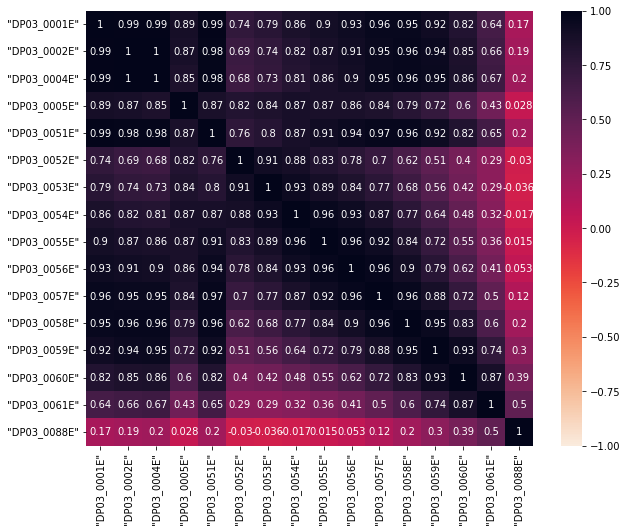

In [24]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_eco_data_an.corr(), vmin=-1, vmax=1, annot=True, cmap=sns.cm.rocket_r)

In [25]:
df_eco_metadata

,GEO_ID,id
0,NAME,Geographic Area Name
1,DP03_0001E,Estimate!!EMPLOYMENT STATUS!!Population 16 yea...
2,DP03_0001M,Margin of Error!!EMPLOYMENT STATUS!!Population...
3,DP03_0001PE,Percent!!EMPLOYMENT STATUS!!Population 16 year...
4,DP03_0001PM,Percent Margin of Error!!EMPLOYMENT STATUS!!Po...
...,...,...
544,DP03_0136PM,Percent Margin of Error!!PERCENTAGE OF FAMILIE...
545,DP03_0137E,Estimate!!PERCENTAGE OF FAMILIES AND PEOPLE WH...
546,DP03_0137M,Margin of Error!!PERCENTAGE OF FAMILIES AND PE...
547,DP03_0137PE,Percent!!PERCENTAGE OF FAMILIES AND PEOPLE WHO...


## Health Insurance Data

Chosen Variables:

"S2701_C01_001E","Estimate!!Total!!Civilian noninstitutionalized population"

"S2701_C01_002E","Estimate!!Total!!Civilian noninstitutionalized population!!AGE!!Under 6 years"

"S2701_C01_003E","Estimate!!Total!!Civilian noninstitutionalized population!!AGE!!6 to 18 years"

"S2701_C01_004E","Estimate!!Total!!Civilian noninstitutionalized population!!AGE!!19 to 25 years"

"S2701_C01_005E","Estimate!!Total!!Civilian noninstitutionalized population!!AGE!!26 to 34 years"

"S2701_C01_006E","Estimate!!Total!!Civilian noninstitutionalized population!!AGE!!35 to 44 years"

"S2701_C01_007E","Estimate!!Total!!Civilian noninstitutionalized population!!AGE!!45 to 54 years"

"S2701_C01_008E","Estimate!!Total!!Civilian noninstitutionalized population!!AGE!!55 to 64 years"

"S2701_C01_009E","Estimate!!Total!!Civilian noninstitutionalized population!!AGE!!65 to 74 years"

"S2701_C01_010E","Estimate!!Total!!Civilian noninstitutionalized population!!AGE!!75 years and older"

"S2701_C01_011E","Estimate!!Total!!Civilian noninstitutionalized population!!AGE!!Under 19 years"

"S2701_C01_012E","Estimate!!Total!!Civilian noninstitutionalized population!!AGE!!19 to 64 years"

"S2701_C01_013E","Estimate!!Total!!Civilian noninstitutionalized population!!AGE!!65 years and older"

"S2701_C02_001E","Estimate!!Insured!!Civilian noninstitutionalized population"

"S2701_C02_002E","Estimate!!Insured!!Civilian noninstitutionalized population!!AGE!!Under 6 years"

"S2701_C02_003E","Estimate!!Insured!!Civilian noninstitutionalized population!!AGE!!6 to 18 years"

"S2701_C02_004E","Estimate!!Insured!!Civilian noninstitutionalized population!!AGE!!19 to 25 years"

"S2701_C02_005E","Estimate!!Insured!!Civilian noninstitutionalized population!!AGE!!26 to 34 years"

"S2701_C02_006E","Estimate!!Insured!!Civilian noninstitutionalized population!!AGE!!35 to 44 years"

"S2701_C02_007E","Estimate!!Insured!!Civilian noninstitutionalized population!!AGE!!45 to 54 years"

"S2701_C02_008E","Estimate!!Insured!!Civilian noninstitutionalized population!!AGE!!55 to 64 years"

"S2701_C02_009E","Estimate!!Insured!!Civilian noninstitutionalized population!!AGE!!65 to 74 years"

"S2701_C02_010E","Estimate!!Insured!!Civilian noninstitutionalized population!!AGE!!75 years and older"

"S2701_C02_011E","Estimate!!Insured!!Civilian noninstitutionalized population!!AGE!!Under 19 years"

"S2701_C02_012E","Estimate!!Insured!!Civilian noninstitutionalized population!!AGE!!19 to 64 years"

"S2701_C02_013E","Estimate!!Insured!!Civilian noninstitutionalized population!!AGE!!65 years and older"

"S2701_C04_001E","Estimate!!Uninsured!!Civilian noninstitutionalized population"

"S2701_C04_002E","Estimate!!Uninsured!!Civilian noninstitutionalized population!!AGE!!Under 6 years"

"S2701_C04_003E","Estimate!!Uninsured!!Civilian noninstitutionalized population!!AGE!!6 to 18 years"

"S2701_C04_004E","Estimate!!Uninsured!!Civilian noninstitutionalized population!!AGE!!19 to 25 years"

"S2701_C04_005E","Estimate!!Uninsured!!Civilian noninstitutionalized population!!AGE!!26 to 34 years"

"S2701_C04_006E","Estimate!!Uninsured!!Civilian noninstitutionalized population!!AGE!!35 to 44 years"

"S2701_C04_007E","Estimate!!Uninsured!!Civilian noninstitutionalized population!!AGE!!45 to 54 years"

"S2701_C04_008E","Estimate!!Uninsured!!Civilian noninstitutionalized population!!AGE!!55 to 64 years"

"S2701_C04_009E","Estimate!!Uninsured!!Civilian noninstitutionalized population!!AGE!!65 to 74 years"

"S2701_C04_010E","Estimate!!Uninsured!!Civilian noninstitutionalized population!!AGE!!75 years and older"

"S2701_C04_011E","Estimate!!Uninsured!!Civilian noninstitutionalized population!!AGE!!Under 19 years"

"S2701_C04_012E","Estimate!!Uninsured!!Civilian noninstitutionalized population!!AGE!!19 to 64 years"

"S2701_C04_013E","Estimate!!Uninsured!!Civilian noninstitutionalized population!!AGE!!65 years and older"


In [26]:
columns = ["GEO_ID", "NAME", "S2701_C01_001E",
"S2701_C01_002E",
"S2701_C01_003E","S2701_C01_004E",
"S2701_C01_005E",
"S2701_C01_006E",
"S2701_C01_007E",
"S2701_C01_008E",
"S2701_C01_009E",
"S2701_C01_010E","S2701_C01_011E",
"S2701_C01_012E",
"S2701_C01_013E",
"S2701_C02_001E",
"S2701_C02_002E",
"S2701_C02_003E",
"S2701_C02_004E",
"S2701_C02_005E",
"S2701_C02_006E",
"S2701_C02_007E",
"S2701_C02_008E","S2701_C02_009E",
"S2701_C02_010E",
"S2701_C02_011E",
"S2701_C02_012E",
"S2701_C02_013E",
"S2701_C04_001E",
"S2701_C04_002E",
"S2701_C04_003E",
"S2701_C04_004E",
"S2701_C04_005E",
"S2701_C04_006E",
"S2701_C04_007E",
"S2701_C04_008E","S2701_C04_009E",
"S2701_C04_010E",
"S2701_C04_011E",
"S2701_C04_012E",
"S2701_C04_013E"]

In [27]:
df_health_data = df_health_data[columns]
df_health_data

,GEO_ID,NAME,S2701_C01_001E,S2701_C01_002E,S2701_C01_003E,S2701_C01_004E,S2701_C01_005E,S2701_C01_006E,S2701_C01_007E,S2701_C01_008E,...,S2701_C04_004E,S2701_C04_005E,S2701_C04_006E,S2701_C04_007E,S2701_C04_008E,S2701_C04_009E,S2701_C04_010E,S2701_C04_011E,S2701_C04_012E,S2701_C04_013E
0,id,Geographic Area Name,Estimate!!Total!!Civilian noninstitutionalized...,Estimate!!Total!!Civilian noninstitutionalized...,Estimate!!Total!!Civilian noninstitutionalized...,Estimate!!Total!!Civilian noninstitutionalized...,Estimate!!Total!!Civilian noninstitutionalized...,Estimate!!Total!!Civilian noninstitutionalized...,Estimate!!Total!!Civilian noninstitutionalized...,Estimate!!Total!!Civilian noninstitutionalized...,...,Estimate!!Uninsured!!Civilian noninstitutional...,Estimate!!Uninsured!!Civilian noninstitutional...,Estimate!!Uninsured!!Civilian noninstitutional...,Estimate!!Uninsured!!Civilian noninstitutional...,Estimate!!Uninsured!!Civilian noninstitutional...,Estimate!!Uninsured!!Civilian noninstitutional...,Estimate!!Uninsured!!Civilian noninstitutional...,Estimate!!Uninsured!!Civilian noninstitutional...,Estimate!!Uninsured!!Civilian noninstitutional...,Estimate!!Uninsured!!Civilian noninstitutional...
1,8600000US35004,ZCTA5 35004,12019,1004,2070,1064,1783,1602,1200,1569,...,254,268,158,53,74,23,0,0,807,23
2,8600000US35005,ZCTA5 35005,7332,547,1351,359,712,795,968,1161,...,52,215,128,153,69,0,0,39,617,0
3,8600000US35006,ZCTA5 35006,2883,144,525,170,181,367,430,556,...,31,50,27,42,49,0,0,19,199,0
4,8600000US35007,ZCTA5 35007,25979,2275,5052,1800,2821,3834,3893,2948,...,321,720,634,198,207,0,0,394,2080,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33116,8600000US00979,ZCTA5 00979,16045,482,1571,1312,1751,2109,2457,2516,...,340,448,321,253,387,90,0,149,1749,90
33117,8600000US00982,ZCTA5 00982,14318,600,2233,1227,1708,1446,1769,1905,...,220,242,251,186,231,8,0,171,1130,8
33118,8600000US00983,ZCTA5 00983,33888,2045,5038,4063,4086,3711,4081,3497,...,653,1061,518,605,316,23,11,467,3153,34
33119,8600000US00985,ZCTA5 00985,31469,1404,4973,2806,3055,3958,4073,3750,...,380,531,482,395,337,16,18,161,2125,34


In [28]:
df_health_data_an = df_health_data.replace('\D+','0',regex=True)
df_health_data_an = df_health_data_an.apply(pd.to_numeric).drop(columns=["GEO_ID", "NAME"])

### Variables described

In [29]:
df_health_data_an.describe()

,S2701_C01_001E,S2701_C01_002E,S2701_C01_003E,S2701_C01_004E,S2701_C01_005E,S2701_C01_006E,S2701_C01_007E,S2701_C01_008E,S2701_C01_009E,S2701_C01_010E,...,S2701_C04_004E,S2701_C04_005E,S2701_C04_006E,S2701_C04_007E,S2701_C04_008E,S2701_C04_009E,S2701_C04_010E,S2701_C04_011E,S2701_C04_012E,S2701_C04_013E
count,33121.000000,33121.000000,33121.000000,33121.000000,33121.000000,33121.000000,33121.000000,33121.000000,33121.000000,33121.000000,...,33121.000000,33121.000000,33121.000000,33121.000000,33121.000000,33121.000000,33121.000000,33121.000000,33121.000000,33121.000000
mean,9751.871381,719.451556,1649.612512,924.670179,1203.779777,1235.954802,1281.681411,1279.274177,912.576975,620.771686,...,139.990972,198.936022,176.991365,150.371547,115.727484,28.279219,3.387609,119.801184,733.360345,12.016455
std,14559.612364,1185.906009,2632.353616,1978.638769,2490.710783,2750.059945,3121.733329,3501.589462,3785.347221,937.964589,...,1086.078705,1486.211423,1960.927518,2490.744200,3030.559625,3575.720299,14.276071,277.323764,1817.263854,37.317619
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,690.000000,38.000000,102.000000,42.000000,58.000000,68.000000,84.000000,104.000000,77.000000,50.000000,...,0.000000,3.000000,2.000000,3.000000,3.000000,0.000000,0.000000,0.000000,35.000000,0.000000
50%,2738.000000,176.000000,454.000000,200.000000,260.000000,304.000000,360.000000,409.000000,299.000000,198.000000,...,22.000000,34.000000,29.000000,30.000000,26.000000,0.000000,0.000000,21.000000,159.000000,0.000000
75%,13214.000000,901.000000,2133.000000,1061.000000,1395.000000,1551.000000,1698.000000,1772.000000,1252.000000,830.000000,...,123.000000,180.000000,153.000000,139.000000,112.000000,0.000000,0.000000,113.000000,728.000000,5.000000
max,128131.000000,20328.000000,60180.000000,190250.000000,260340.000000,350440.000000,450540.000000,550640.000000,650740.000000,19197.000000,...,190250.000000,260340.000000,350440.000000,450540.000000,550640.000000,650740.000000,750.000000,5843.000000,190640.000000,913.000000


### Pearson correlation to identify linearity between variables

<AxesSubplot:>

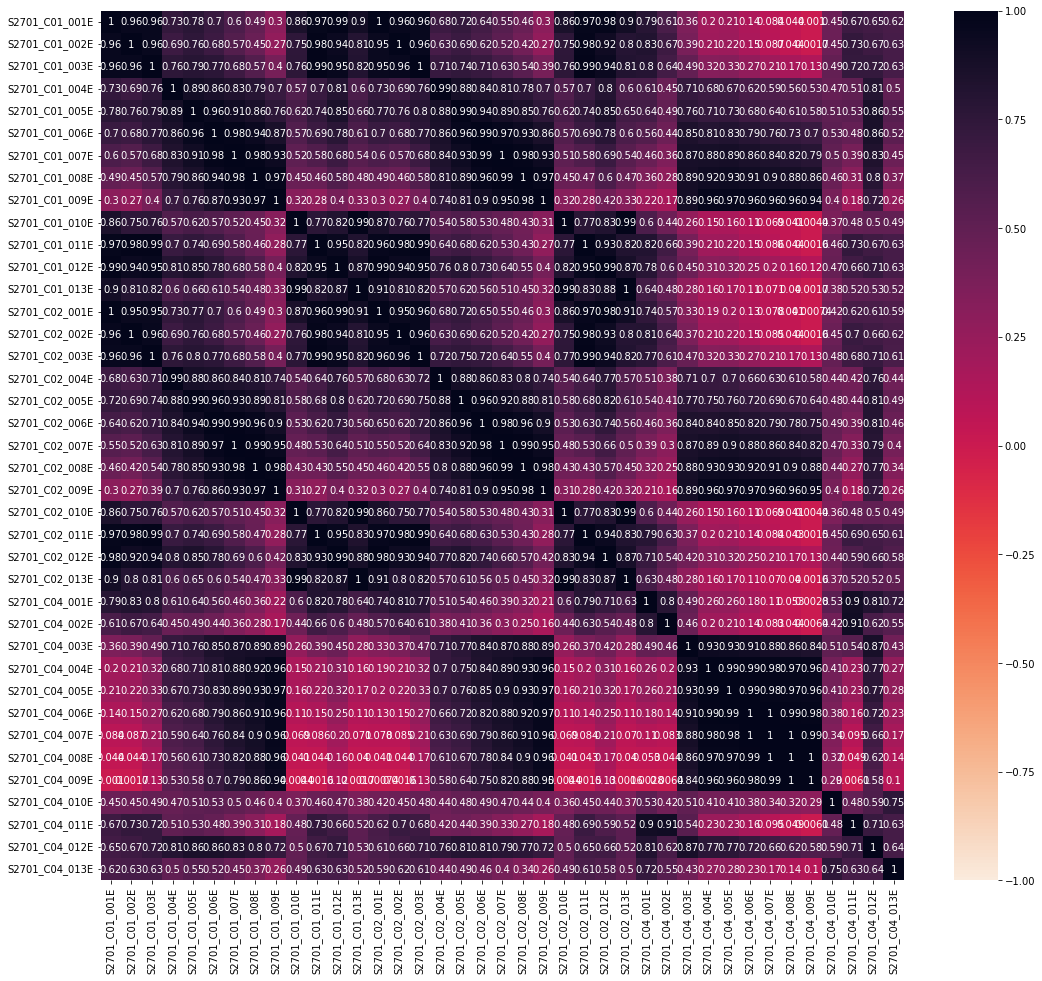

In [30]:
plt.figure(figsize=(18, 16))
sns.heatmap(df_health_data_an.corr(), vmin=-1, vmax=1, annot=True, cmap=sns.cm.rocket_r)

## Demographic Data

Chosen Variables:

"DP05_0001E","Estimate!!SEX AND AGE!!Total population"

"DP05_0005E","Estimate!!SEX AND AGE!!Total population!!Under 5 years"

"DP05_0006E","Estimate!!SEX AND AGE!!Total population!!5 to 9 years"

"DP05_0007E","Estimate!!SEX AND AGE!!Total population!!10 to 14 years"

"DP05_0008E","Estimate!!SEX AND AGE!!Total population!!15 to 19 years"

"DP05_0009E","Estimate!!SEX AND AGE!!Total population!!20 to 24 years"

"DP05_0010E","Estimate!!SEX AND AGE!!Total population!!25 to 34 years"

"DP05_0011E","Estimate!!SEX AND AGE!!Total population!!35 to 44 years"

"DP05_0012E","Estimate!!SEX AND AGE!!Total population!!45 to 54 years"

"DP05_0013E","Estimate!!SEX AND AGE!!Total population!!55 to 59 years"

"DP05_0014E","Estimate!!SEX AND AGE!!Total population!!60 to 64 years"

"DP05_0015E","Estimate!!SEX AND AGE!!Total population!!65 to 74 years"

"DP05_0016E","Estimate!!SEX AND AGE!!Total population!!75 to 84 years"

"DP05_0017E","Estimate!!SEX AND AGE!!Total population!!85 years and over"

"DP05_0018E","Estimate!!SEX AND AGE!!Total population!!Median age (years)"

In [31]:
columns = ["GEO_ID", "NAME", "DP05_0001E",
"DP05_0005E",
"DP05_0006E",
"DP05_0007E",
"DP05_0008E",
"DP05_0009E","DP05_0010E",
"DP05_0011E",
"DP05_0012E",
"DP05_0013E",
"DP05_0014E",
"DP05_0015E",
"DP05_0016E","DP05_0017E",
"DP05_0018E"]

In [32]:
df_dem_data = df_dem_data[columns]
df_dem_data

,GEO_ID,NAME,DP05_0001E,DP05_0005E,DP05_0006E,DP05_0007E,DP05_0008E,DP05_0009E,DP05_0010E,DP05_0011E,DP05_0012E,DP05_0013E,DP05_0014E,DP05_0015E,DP05_0016E,DP05_0017E,DP05_0018E
0,id,Geographic Area Name,Estimate!!SEX AND AGE!!Total population,Estimate!!SEX AND AGE!!Total population!!Under...,Estimate!!SEX AND AGE!!Total population!!5 to ...,Estimate!!SEX AND AGE!!Total population!!10 to...,Estimate!!SEX AND AGE!!Total population!!15 to...,Estimate!!SEX AND AGE!!Total population!!20 to...,Estimate!!SEX AND AGE!!Total population!!25 to...,Estimate!!SEX AND AGE!!Total population!!35 to...,Estimate!!SEX AND AGE!!Total population!!45 to...,Estimate!!SEX AND AGE!!Total population!!55 to...,Estimate!!SEX AND AGE!!Total population!!60 to...,Estimate!!SEX AND AGE!!Total population!!65 to...,Estimate!!SEX AND AGE!!Total population!!75 to...,Estimate!!SEX AND AGE!!Total population!!85 ye...,Estimate!!SEX AND AGE!!Total population!!Media...
1,8600000US35004,ZCTA5 35004,12045,805,1075,898,477,578,2088,1628,1200,886,683,1017,534,176,35.5
2,8600000US35005,ZCTA5 35005,7344,504,453,511,499,214,788,795,968,612,561,798,485,156,44.0
3,8600000US35006,ZCTA5 35006,2883,96,153,303,129,156,183,367,430,296,260,280,201,29,47.2
4,8600000US35007,ZCTA5 35007,26332,1936,1992,1837,1762,1376,3119,3849,3907,1665,1323,2096,1106,364,37.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33116,8600000US00979,ZCTA5 00979,16130,402,532,554,726,1005,1935,2109,2468,1368,1148,1974,1363,546,48.7
33117,8600000US00982,ZCTA5 00982,14346,431,952,795,769,854,1975,1446,1769,957,948,1201,1654,595,44.8
33118,8600000US00983,ZCTA5 00983,33947,1833,1589,1841,2203,2957,4809,3712,4081,1930,1574,4003,2405,1010,40.8
33119,8600000US00985,ZCTA5 00985,31682,1171,1427,1833,2304,2032,3491,3966,4073,1732,2047,4207,2498,901,43.6


In [33]:
df_dem_data_an = df_dem_data.replace('\D+','0',regex=True)
df_dem_data_an = df_dem_data_an.apply(pd.to_numeric).drop(columns=["GEO_ID", "NAME"])

### Variables described

In [34]:
df_dem_data_an.describe()

,DP05_0001E,DP05_0005E,DP05_0006E,DP05_0007E,DP05_0008E,DP05_0009E,DP05_0010E,DP05_0011E,DP05_0012E,DP05_0013E,DP05_0014E,DP05_0015E,DP05_0016E,DP05_0017E,DP05_0018E
count,33121.000000,33121.000000,33121.000000,33121.000000,33121.000000,33121.000000,33121.000000,33121.000000,33121.000000,33121.000000,33121.000000,33121.000000,33121.000000,33121.000000,33121.000000
mean,9903.044956,601.148033,614.024456,640.870505,651.473385,677.631654,1379.506386,1260.218472,1296.993599,676.948462,631.494701,922.523988,481.126717,191.686272,4156.058603
std,14713.921891,995.943409,995.488388,1162.418789,1333.959792,1652.771928,2698.615546,2767.144289,3130.450950,3164.330726,3406.649281,3789.505674,4179.069162,312.565289,1058.044793
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,705.000000,31.000000,34.000000,37.000000,37.000000,30.000000,66.000000,70.000000,85.000000,52.000000,51.000000,78.000000,37.000000,10.000000,3608.000000
50%,2801.000000,146.000000,159.000000,174.000000,171.000000,149.000000,298.000000,314.000000,367.000000,211.000000,202.000000,303.000000,151.000000,51.000000,4108.000000
75%,13475.000000,744.000000,782.000000,817.000000,820.000000,783.000000,1612.000000,1593.000000,1728.000000,922.000000,867.000000,1266.000000,624.000000,242.000000,4705.000000
max,128294.000000,17564.000000,14784.000000,100140.000000,150190.000000,200240.000000,250340.000000,350440.000000,450540.000000,550590.000000,600640.000000,650740.000000,750840.000000,4633.000000,9802.000000


### Pearson correlation to identify linearity between variables

<AxesSubplot:>

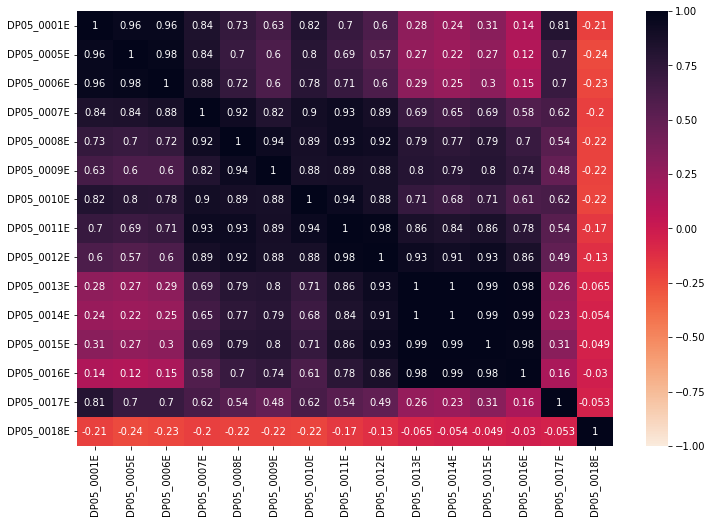

In [35]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_dem_data_an.corr(), vmin=-1, vmax=1, annot=True, cmap=sns.cm.rocket_r)

### Merge all tables

In [36]:
df_tabular_data = pd.merge(df_dem_data, df_eco_data, on="NAME")
df_tabular_data = pd.merge(df_tabular_data, df_health_data, on="NAME")
df_tabular_data

,GEO_ID_x,NAME,DP05_0001E,DP05_0005E,DP05_0006E,DP05_0007E,DP05_0008E,DP05_0009E,DP05_0010E,DP05_0011E,...,S2701_C04_004E,S2701_C04_005E,S2701_C04_006E,S2701_C04_007E,S2701_C04_008E,S2701_C04_009E,S2701_C04_010E,S2701_C04_011E,S2701_C04_012E,S2701_C04_013E
0,8600000US35004,ZCTA5 35004,12045,805,1075,898,477,578,2088,1628,...,254,268,158,53,74,23,0,0,807,23
1,8600000US35005,ZCTA5 35005,7344,504,453,511,499,214,788,795,...,52,215,128,153,69,0,0,39,617,0
2,8600000US35006,ZCTA5 35006,2883,96,153,303,129,156,183,367,...,31,50,27,42,49,0,0,19,199,0
3,8600000US35007,ZCTA5 35007,26332,1936,1992,1837,1762,1376,3119,3849,...,321,720,634,198,207,0,0,394,2080,0
4,8600000US35010,ZCTA5 35010,20613,1306,1465,944,1217,1128,2513,2106,...,295,288,370,324,289,0,0,133,1566,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33115,8600000US00979,ZCTA5 00979,16130,402,532,554,726,1005,1935,2109,...,340,448,321,253,387,90,0,149,1749,90
33116,8600000US00982,ZCTA5 00982,14346,431,952,795,769,854,1975,1446,...,220,242,251,186,231,8,0,171,1130,8
33117,8600000US00983,ZCTA5 00983,33947,1833,1589,1841,2203,2957,4809,3712,...,653,1061,518,605,316,23,11,467,3153,34
33118,8600000US00985,ZCTA5 00985,31682,1171,1427,1833,2304,2032,3491,3966,...,380,531,482,395,337,16,18,161,2125,34


# Regression Approach for approximating Laboratory profit per ZCTA
Feature Engineering, Feature Selection, Feature Crossing, Model Selection

## Feature Engineering

In [37]:
df_tabular_data_only_features = df_tabular_data.drop(columns=["NAME", "GEO_ID_x", "GEO_ID_y", "\"GEO_ID\""])
df_tabular_data_only_features.replace('\D+','0',regex=True,inplace=True)
df_tabular_data_only_features = df_tabular_data_only_features.apply(pd.to_numeric)
df_tabular_data_only_features

,DP05_0001E,DP05_0005E,DP05_0006E,DP05_0007E,DP05_0008E,DP05_0009E,DP05_0010E,DP05_0011E,DP05_0012E,DP05_0013E,...,S2701_C04_004E,S2701_C04_005E,S2701_C04_006E,S2701_C04_007E,S2701_C04_008E,S2701_C04_009E,S2701_C04_010E,S2701_C04_011E,S2701_C04_012E,S2701_C04_013E
0,12045,805,1075,898,477,578,2088,1628,1200,886,...,254,268,158,53,74,23,0,0,807,23
1,7344,504,453,511,499,214,788,795,968,612,...,52,215,128,153,69,0,0,39,617,0
2,2883,96,153,303,129,156,183,367,430,296,...,31,50,27,42,49,0,0,19,199,0
3,26332,1936,1992,1837,1762,1376,3119,3849,3907,1665,...,321,720,634,198,207,0,0,394,2080,0
4,20613,1306,1465,944,1217,1128,2513,2106,2950,1512,...,295,288,370,324,289,0,0,133,1566,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33115,16130,402,532,554,726,1005,1935,2109,2468,1368,...,340,448,321,253,387,90,0,149,1749,90
33116,14346,431,952,795,769,854,1975,1446,1769,957,...,220,242,251,186,231,8,0,171,1130,8
33117,33947,1833,1589,1841,2203,2957,4809,3712,4081,1930,...,653,1061,518,605,316,23,11,467,3153,34
33118,31682,1171,1427,1833,2304,2032,3491,3966,4073,1732,...,380,531,482,395,337,16,18,161,2125,34


In [38]:
zctas = df_tabular_data["NAME"].apply(lambda a: int(a[6:])).to_dict()
zctas_indices = dict((v, k) for k, v in zctas.items())

In [39]:
X = []
y = []
for _, row in df_geocode.iterrows():
    try:
        zcta_index = zctas_indices[row['zcta']]
        lab_zcta_features = df_tabular_data_only_features.iloc[zcta_index]
        X.append(np.array(lab_zcta_features))
        y.append(row['lab_profit'])
    except:
        pass
X = np.array(X)
y = np.array(y)
X.shape

(116, 70)

### Add Polynomial features

In [40]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)
poly.fit(X)
X = poly.transform(X)

In [41]:
X.shape

(116, 2556)

### Standardize Features

In [42]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X

array([[ 0.        ,  2.84455043,  2.73149481, ...,  8.7470147 ,
         9.09742163,  8.09214288],
       [ 0.        ,  0.39461191,  0.41111767, ..., -0.29456561,
        -0.30621026, -0.35032714],
       [ 0.        ,  0.51969241,  0.502884  , ..., -0.22937385,
        -0.2142859 , -0.27992208],
       ...,
       [ 0.        , -1.61100321, -1.30753455, ..., -0.36992302,
        -0.3237438 , -0.35386545],
       [ 0.        , -0.25324092,  0.04274141, ..., -0.32031449,
        -0.25260883, -0.2654078 ],
       [ 0.        ,  0.27950935,  0.50616137, ...,  0.40547225,
         0.11008087, -0.14330014]])

## Feature Selection

In [43]:
from sklearn.feature_selection import RFECV

# Number of samples ~= Number of parameters * 10 
MIN_FEATURES = 10

## Metrics Selection

Root Mean Squared Error: RMSE is the most widely used metric for regression tasks and is the square root of the averaged squared difference between the target value and the value predicted by the model. *It is preferred more in some cases because the errors are first squared before averaging which poses a high penalty on large errors.* This implies that RMSE is useful when large errors are undesired.

R-squared (Coefficient of determination) represents the coefficient of how well the values fit compared to the original values.  R-squared explains to what extent the variance of one variable explains the variance of the second variable. *So, if the R2 of a model is 0.50, then approximately half of the observed variation can be explained by the model's inputs.*

In [44]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Model Selection

In [45]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, BayesianRidge, Ridge, ElasticNet, Lasso
from sklearn.svm import LinearSVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor

models = {
    'lin_reg':LinearRegression, 
    'bay_ridge':BayesianRidge, 
    'ridge':Ridge, 
    'elastic':ElasticNet, 
    'lasso':Lasso, 
    'svr':LinearSVR, 
    'mlp':MLPRegressor,
    'knn':KNeighborsRegressor,
    'boosting':GradientBoostingRegressor
}

n_splits = 5

kf = KFold(n_splits=n_splits)

In [46]:
results = []
for model_name in models.keys():
    regf = models[model_name]()
    selector = RFECV(regf, step=30, cv=5, min_features_to_select=MIN_FEATURES)
    try:
        selector = selector.fit(X, y)
        trf = selector.transform
    except:
        selector = None
        trf = lambda a: a
    
    rmse = 0.0
    mae = 0.0
    r2 = 0.0
    print(f'Current model: {model_name}...')
    for train, test in tqdm(kf.split(X), total=n_splits):
        X_train, y_train = trf(X[train]), y[train]
        X_test, y_test = trf(X[test]), y[test]
        regf = models[model_name]()
        regf.fit(X_train, y_train)
        preds = regf.predict(X_test)
        rmse += mean_squared_error(y_test, preds, squared=False)
        mae += mean_absolute_error(y_test, preds)
        r2 += r2_score(y_test, preds)
    rmse /= n_splits
    mae /= n_splits
    r2 /= n_splits
    
    results.append({
        'model_name':model_name,
        'selector':selector,
        'rmse':rmse,
        'mae':mae,
        'r2':r2
    })

Current model: lin_reg...


100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 867.63it/s]


Current model: bay_ridge...


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 10.74it/s]


Current model: ridge...


100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 705.66it/s]
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.517e+12, tolerance: 1.016e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.517e+12, tolerance: 1.016e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. 

/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.575e+12, tolerance: 1.016e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.577e+12, tolerance: 1.016e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.635e+12, tolerance: 1.016e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.629e+12, tolerance: 1.016e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.000e+12, tolerance: 1.016e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.026e+12, tolerance: 1.016e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.130e+12, tolerance: 1.184e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.131e+12, tolerance: 1.184e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.155e+12, tolerance: 1.184e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.154e+12, tolerance: 1.184e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.232e+12, tolerance: 1.184e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.231e+12, tolerance: 1.184e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.014e+11, tolerance: 1.184e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.474e+12, tolerance: 1.329e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.546e+12, tolerance: 1.329e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.548e+12, tolerance: 1.329e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.641e+12, tolerance: 1.329e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.643e+12, tolerance: 1.329e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.789e+12, tolerance: 1.329e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.780e+12, tolerance: 1.329e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.895e+12, tolerance: 1.003e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.895e+12, tolerance: 1.003e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.940e+12, tolerance: 1.003e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.938e+12, tolerance: 1.003e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.986e+12, tolerance: 1.003e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.985e+12, tolerance: 1.003e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.131e+12, tolerance: 1.003e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.163e+12, tolerance: 1.003e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.141e+12, tolerance: 1.040e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.142e+12, tolerance: 1.040e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.170e+12, tolerance: 1.040e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.173e+12, tolerance: 1.040e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.334e+12, tolerance: 1.040e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.358e+12, tolerance: 1.040e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.103e+10, tolerance: 1.040e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.837e+12, tolerance: 1.397e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.898e+12, tolerance: 1.397e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.903e+12, tolerance: 1.397e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.002e+13, tolerance: 1.397e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.002e+13, tolerance: 1.397e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.022e+13, tolerance: 1.397e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.026e+13, tolerance: 1.397e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

Current model: elastic...


100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 408.07it/s]
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.557e+11, tolerance: 1.016e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.559e+11, tolerance: 1.016e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. 

/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.579e+11, tolerance: 1.016e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.588e+11, tolerance: 1.016e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.719e+11, tolerance: 1.016e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.646e+11, tolerance: 1.016e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.218e+11, tolerance: 1.016e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.305e+11, tolerance: 1.016e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.106e+12, tolerance: 1.184e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.101e+12, tolerance: 1.184e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.201e+12, tolerance: 1.184e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.258e+12, tolerance: 1.184e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.218e+12, tolerance: 1.184e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.220e+12, tolerance: 1.184e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.473e+12, tolerance: 1.184e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.503e+12, tolerance: 1.184e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.984e+12, tolerance: 1.329e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.049e+12, tolerance: 1.329e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.359e+12, tolerance: 1.329e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.374e+12, tolerance: 1.329e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.519e+12, tolerance: 1.329e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.547e+12, tolerance: 1.329e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.036e+12, tolerance: 1.329e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.040e+12, tolerance: 1.329e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.987e+12, tolerance: 1.003e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.977e+12, tolerance: 1.003e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.952e+12, tolerance: 1.003e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.959e+12, tolerance: 1.003e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.027e+12, tolerance: 1.003e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.026e+12, tolerance: 1.003e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.210e+12, tolerance: 1.003e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.284e+12, tolerance: 1.003e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.996e+12, tolerance: 1.040e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.999e+12, tolerance: 1.040e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.866e+12, tolerance: 1.040e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.821e+12, tolerance: 1.040e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.115e+12, tolerance: 1.040e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.157e+12, tolerance: 1.040e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.858e+12, tolerance: 1.397e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.848e+12, tolerance: 1.397e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.783e+12, tolerance: 1.397e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.784e+12, tolerance: 1.397e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.752e+12, tolerance: 1.397e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.754e+12, tolerance: 1.397e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.977e+12, tolerance: 1.397e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.985e+12, tolerance: 1.397e+10
  model = cd_fast.enet_coordinate_descent(
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

Current model: lasso...


  0%|                                                     | 0/5 [00:00<?, ?it/s]/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.816e+10, tolerance: 1.003e+10
  model = cd_fast.enet_coordinate_descent(
100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 487.43it/s]


Current model: svr...


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 1297.98it/s]
/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Current model: mlp...


  0%|                                                     | 0/5 [00:00<?, ?it/s]/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
 20%|█████████                                    | 1/5 [00:00<00:02,  1.59it/s]/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
 40%|██████████████████                           | 2/5 [00:01<00:01,  1.53it/s]/home/vmachado/Documents/elogroup_chall/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warn

Current model: knn...


100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 529.58it/s]


Current model: boosting...


100%|█████████████████████████████████████████████| 5/5 [00:08<00:00,  1.66s/it]


In [47]:
results

[{'model_name': 'lin_reg',
  'selector': RFECV(cv=5, estimator=LinearRegression(), min_features_to_select=10, step=30),
  'rmse': 1276051.9851604714,
  'mae': 601655.9837952916,
  'r2': -1.3782131182414752},
 {'model_name': 'bay_ridge',
  'selector': RFECV(cv=5, estimator=BayesianRidge(), min_features_to_select=10, step=30),
  'rmse': 735592.4118986577,
  'mae': 424481.43639492674,
  'r2': 0.3034230559156798},
 {'model_name': 'ridge',
  'selector': RFECV(cv=5, estimator=Ridge(), min_features_to_select=10, step=30),
  'rmse': 574600.0319969977,
  'mae': 362195.82272509456,
  'r2': 0.6275612098866068},
 {'model_name': 'elastic',
  'selector': RFECV(cv=5, estimator=ElasticNet(), min_features_to_select=10, step=30),
  'rmse': 506856.62935745844,
  'mae': 314807.37795222155,
  'r2': 0.6058224463638087},
 {'model_name': 'lasso',
  'selector': RFECV(cv=5, estimator=Lasso(), min_features_to_select=10, step=30),
  'rmse': 650805.3140109039,
  'mae': 404834.93011234736,
  'r2': 0.475141045111276

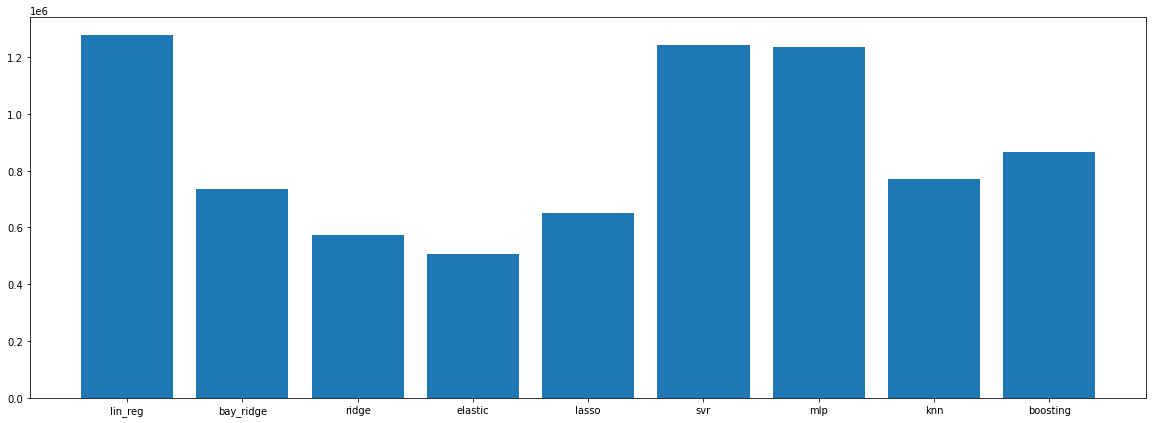

In [48]:
plt.bar([item['model_name'] for item in results], [item['rmse'] for item in results])
plt.show()

### Ensembling best methods from distinct paradigms

In [49]:
model_name = 'ensemble'
estimators = [
    ('knn', KNeighborsRegressor()),
    ('boosting', GradientBoostingRegressor()),
    ('elastic', ElasticNet()),
    ('bay_ridge', BayesianRidge()),
]
# Using ElasticNet selector
selector = results[3]['selector']

try:
    trf = selector.transform
except:
    selector = None
    trf = lambda a: a
    
rmse = 0.0
mae = 0.0
r2 = 0.0
print(f'Current model: {model_name}...')
for train, test in tqdm(kf.split(X), total=n_splits):
    X_train, y_train = trf(X[train]), y[train]
    X_test, y_test = trf(X[test]), y[test]
    regf = StackingRegressor(
         estimators=estimators,
         final_estimator=ElasticNet()
    )
    regf.fit(X_train, y_train)
    preds = regf.predict(X_test)
    rmse += mean_squared_error(y_test, preds, squared=False)
    mae += mean_absolute_error(y_test, preds)
    r2 += r2_score(y_test, preds)
rmse /= n_splits
mae /= n_splits
r2 /= n_splits

result = {
    'model_name':model_name,
    'selector':selector,
    'rmse':rmse,
    'mae':mae,
    'r2':r2
}
results.append(result)
result

Current model: ensemble...


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  4.13it/s]


{'model_name': 'ensemble',
 'selector': RFECV(cv=5, estimator=ElasticNet(), min_features_to_select=10, step=30),
 'rmse': 484277.385718098,
 'mae': 309461.08104919066,
 'r2': 0.7181914509396776}

### Best results:
 {'model_name': 'ensemble',
 
  'selector': RFECV(cv=5, estimator=ElasticNet(), min_features_to_select=10, step=30),
  
  'rmse': 484277.385718098,
  
  'mae': 309461.08104919066,
  
  'r2': 0.7181914509396776},

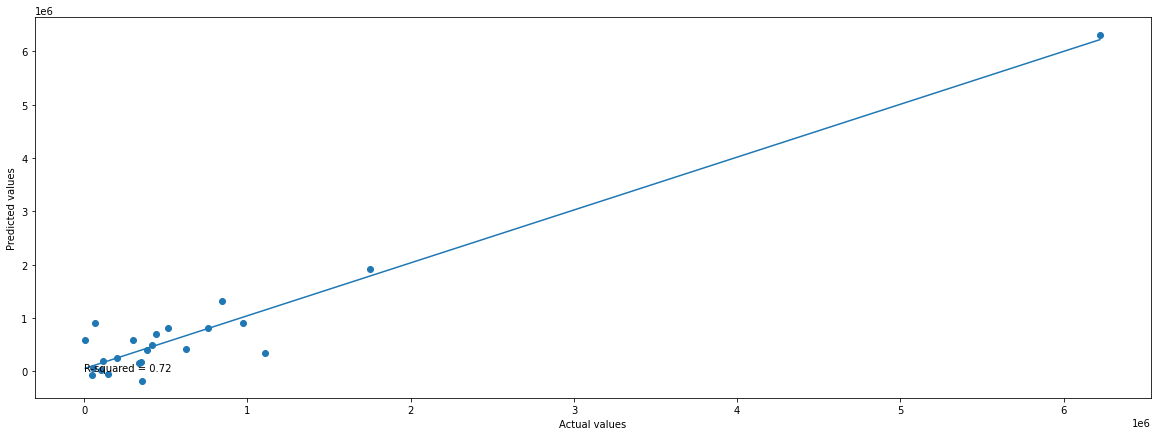

In [50]:
plt.scatter(y_test, preds)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, preds, 1))(np.unique(y_test)))
plt.text(0.6, 0.5, 'R-squared = %0.2f' % r2)
plt.show()

In [51]:
results

[{'model_name': 'lin_reg',
  'selector': RFECV(cv=5, estimator=LinearRegression(), min_features_to_select=10, step=30),
  'rmse': 1276051.9851604714,
  'mae': 601655.9837952916,
  'r2': -1.3782131182414752},
 {'model_name': 'bay_ridge',
  'selector': RFECV(cv=5, estimator=BayesianRidge(), min_features_to_select=10, step=30),
  'rmse': 735592.4118986577,
  'mae': 424481.43639492674,
  'r2': 0.3034230559156798},
 {'model_name': 'ridge',
  'selector': RFECV(cv=5, estimator=Ridge(), min_features_to_select=10, step=30),
  'rmse': 574600.0319969977,
  'mae': 362195.82272509456,
  'r2': 0.6275612098866068},
 {'model_name': 'elastic',
  'selector': RFECV(cv=5, estimator=ElasticNet(), min_features_to_select=10, step=30),
  'rmse': 506856.62935745844,
  'mae': 314807.37795222155,
  'r2': 0.6058224463638087},
 {'model_name': 'lasso',
  'selector': RFECV(cv=5, estimator=Lasso(), min_features_to_select=10, step=30),
  'rmse': 650805.3140109039,
  'mae': 404834.93011234736,
  'r2': 0.475141045111276

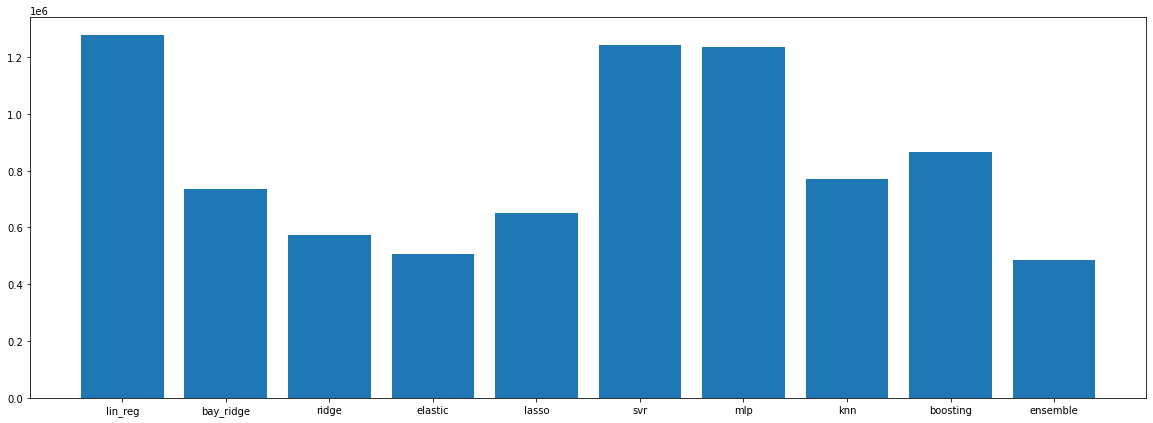

In [52]:
plt.bar([item['model_name'] for item in results], [item['rmse'] for item in results])
plt.show()

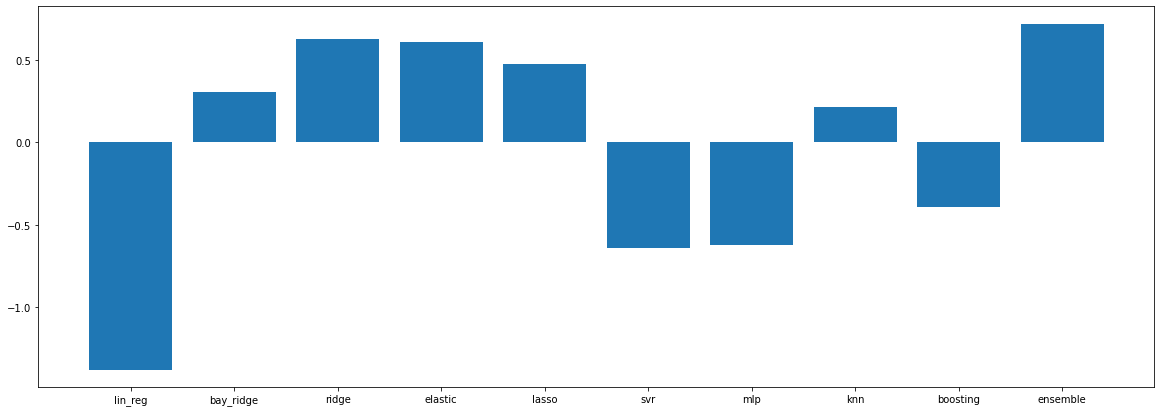

In [53]:
plt.bar([item['model_name'] for item in results], [item['r2'] for item in results])
plt.show()

### Selected features

In [54]:
selector.get_feature_names_out()

array(['x5', 'x23', 'x31', 'x187', 'x210', 'x213', 'x217', 'x221', 'x242',
       'x255', 'x288', 'x302', 'x322', 'x355', 'x371', 'x415', 'x419',
       'x683', 'x703', 'x704', 'x908', 'x931', 'x937', 'x944', 'x968',
       'x1187', 'x1207', 'x1289', 'x1376', 'x1428', 'x1730', 'x1736',
       'x1830', 'x2127', 'x2233', 'x2287'], dtype=object)

# Inference

In [55]:
all_labs_zcta = list(df_geocode['zcta'])
all_zctas = list(df_tabular_data['NAME'])
df_tabular_data["NAME"] = df_tabular_data["NAME"].apply(lambda a: int(a[6:]))
df_tabular_data

,GEO_ID_x,NAME,DP05_0001E,DP05_0005E,DP05_0006E,DP05_0007E,DP05_0008E,DP05_0009E,DP05_0010E,DP05_0011E,...,S2701_C04_004E,S2701_C04_005E,S2701_C04_006E,S2701_C04_007E,S2701_C04_008E,S2701_C04_009E,S2701_C04_010E,S2701_C04_011E,S2701_C04_012E,S2701_C04_013E
0,8600000US35004,35004,12045,805,1075,898,477,578,2088,1628,...,254,268,158,53,74,23,0,0,807,23
1,8600000US35005,35005,7344,504,453,511,499,214,788,795,...,52,215,128,153,69,0,0,39,617,0
2,8600000US35006,35006,2883,96,153,303,129,156,183,367,...,31,50,27,42,49,0,0,19,199,0
3,8600000US35007,35007,26332,1936,1992,1837,1762,1376,3119,3849,...,321,720,634,198,207,0,0,394,2080,0
4,8600000US35010,35010,20613,1306,1465,944,1217,1128,2513,2106,...,295,288,370,324,289,0,0,133,1566,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33115,8600000US00979,979,16130,402,532,554,726,1005,1935,2109,...,340,448,321,253,387,90,0,149,1749,90
33116,8600000US00982,982,14346,431,952,795,769,854,1975,1446,...,220,242,251,186,231,8,0,171,1130,8
33117,8600000US00983,983,33947,1833,1589,1841,2203,2957,4809,3712,...,653,1061,518,605,316,23,11,467,3153,34
33118,8600000US00985,985,31682,1171,1427,1833,2304,2032,3491,3966,...,380,531,482,395,337,16,18,161,2125,34


In [56]:
all_zctas = list(map(lambda a: int(a[6:]),all_zctas))

In [57]:
indices = []
X_inf = []

for i, zcta in enumerate(all_zctas):
    if zcta not in all_labs_zcta:
        indices.append(i)
len(indices)

33017

In [58]:
df_tabular_data_inf = df_tabular_data.iloc[indices]
df_tabular_data_inf

,GEO_ID_x,NAME,DP05_0001E,DP05_0005E,DP05_0006E,DP05_0007E,DP05_0008E,DP05_0009E,DP05_0010E,DP05_0011E,...,S2701_C04_004E,S2701_C04_005E,S2701_C04_006E,S2701_C04_007E,S2701_C04_008E,S2701_C04_009E,S2701_C04_010E,S2701_C04_011E,S2701_C04_012E,S2701_C04_013E
0,8600000US35004,35004,12045,805,1075,898,477,578,2088,1628,...,254,268,158,53,74,23,0,0,807,23
1,8600000US35005,35005,7344,504,453,511,499,214,788,795,...,52,215,128,153,69,0,0,39,617,0
2,8600000US35006,35006,2883,96,153,303,129,156,183,367,...,31,50,27,42,49,0,0,19,199,0
3,8600000US35007,35007,26332,1936,1992,1837,1762,1376,3119,3849,...,321,720,634,198,207,0,0,394,2080,0
4,8600000US35010,35010,20613,1306,1465,944,1217,1128,2513,2106,...,295,288,370,324,289,0,0,133,1566,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33115,8600000US00979,979,16130,402,532,554,726,1005,1935,2109,...,340,448,321,253,387,90,0,149,1749,90
33116,8600000US00982,982,14346,431,952,795,769,854,1975,1446,...,220,242,251,186,231,8,0,171,1130,8
33117,8600000US00983,983,33947,1833,1589,1841,2203,2957,4809,3712,...,653,1061,518,605,316,23,11,467,3153,34
33118,8600000US00985,985,31682,1171,1427,1833,2304,2032,3491,3966,...,380,531,482,395,337,16,18,161,2125,34


### Get features for the remaining data

In [59]:
df_tabular_data_only_features2 = df_tabular_data_inf.drop(columns=["NAME", "GEO_ID_x", "GEO_ID_y", "\"GEO_ID\""])
df_tabular_data_only_features2.replace('\D+','0',regex=True,inplace=True)
df_tabular_data_only_features2 = df_tabular_data_only_features2.apply(pd.to_numeric)
df_tabular_data_only_features2

,DP05_0001E,DP05_0005E,DP05_0006E,DP05_0007E,DP05_0008E,DP05_0009E,DP05_0010E,DP05_0011E,DP05_0012E,DP05_0013E,...,S2701_C04_004E,S2701_C04_005E,S2701_C04_006E,S2701_C04_007E,S2701_C04_008E,S2701_C04_009E,S2701_C04_010E,S2701_C04_011E,S2701_C04_012E,S2701_C04_013E
0,12045,805,1075,898,477,578,2088,1628,1200,886,...,254,268,158,53,74,23,0,0,807,23
1,7344,504,453,511,499,214,788,795,968,612,...,52,215,128,153,69,0,0,39,617,0
2,2883,96,153,303,129,156,183,367,430,296,...,31,50,27,42,49,0,0,19,199,0
3,26332,1936,1992,1837,1762,1376,3119,3849,3907,1665,...,321,720,634,198,207,0,0,394,2080,0
4,20613,1306,1465,944,1217,1128,2513,2106,2950,1512,...,295,288,370,324,289,0,0,133,1566,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33115,16130,402,532,554,726,1005,1935,2109,2468,1368,...,340,448,321,253,387,90,0,149,1749,90
33116,14346,431,952,795,769,854,1975,1446,1769,957,...,220,242,251,186,231,8,0,171,1130,8
33117,33947,1833,1589,1841,2203,2957,4809,3712,4081,1930,...,653,1061,518,605,316,23,11,467,3153,34
33118,31682,1171,1427,1833,2304,2032,3491,3966,4073,1732,...,380,531,482,395,337,16,18,161,2125,34


In [60]:
zctas_inf = list(df_tabular_data_inf['NAME'])
X_inf = np.array(df_tabular_data_only_features2)
X_inf = poly.transform(X_inf)

### Use selected model for inference

In [61]:
regf = StackingRegressor(
     estimators=estimators,
     final_estimator=ElasticNet()
)
regf.fit(selector.transform(X), y)

StackingRegressor(estimators=[('knn', KNeighborsRegressor()),
                              ('boosting', GradientBoostingRegressor()),
                              ('elastic', ElasticNet()),
                              ('bay_ridge', BayesianRidge())],
                  final_estimator=ElasticNet())

In [78]:
preds = regf.predict(selector.transform(scaler.transform(X_inf)))
preds

array([  47851.36083503, -116909.7060245 ,  -17951.46785451, ...,
        490596.17677641,  114727.32251567, 1837098.81774498])

### Select top 100 profit prediction as candidates

In [79]:
preds = list(zip(zctas_inf, preds))
preds = sorted(preds, key=lambda a: a[1], reverse=True)

MAX_CANDIDATES = 100
preds = preds[:MAX_CANDIDATES]
preds

[(8701, 17654219.497277375),
 (32461, 11436258.147032028),
 (47906, 10067632.919309746),
 (11219, 9999806.051583692),
 (77449, 9919125.578760132),
 (79936, 8941111.016670356),
 (60629, 8535607.346337773),
 (90011, 8123890.244935467),
 (91331, 7967120.620571622),
 (90650, 7874413.825919197),
 (90201, 7719893.132603816),
 (11385, 7590705.327096659),
 (77494, 7311087.095073322),
 (11368, 7154918.765431549),
 (10467, 6893529.8791735275),
 (11208, 6872707.516269234),
 (92335, 6844393.8727220325),
 (11230, 6511017.441371509),
 (926, 6351397.214772028),
 (90044, 6264011.475959114),
 (11236, 6197636.64097325),
 (78666, 6190369.539035386),
 (11234, 5871380.858972868),
 (11214, 5789518.4416868435),
 (91911, 5708268.086492057),
 (92804, 5631178.329777075),
 (90280, 5537761.722076308),
 (93307, 5528510.054100419),
 (92503, 5482542.4544193605),
 (60804, 5468831.784583951),
 (90805, 5419255.063887542),
 (14850, 5388166.814801206),
 (10458, 5236173.461757945),
 (78521, 5191477.245873467),
 (96797, 51

In [64]:
zctas_best_profit_estimative = list(map(lambda a: a[0], preds))

## Plot candidates on map

In [65]:
nomi = pgeocode.Nominatim('us')

locations = []
for zcta in zctas_best_profit_estimative:
    location = nomi.query_postal_code(zcta)
    lat, lon = location.latitude, location.longitude
    locations.append(
        (lat,lon)
    )

In [66]:
df_locs = pd.DataFrame()
latitude, longitude = [], []

for loc in locations:
    latitude.append(loc[0])
    longitude.append(loc[1])
    
df_locs['zctas'] = zctas_best_profit_estimative
df_locs['latitude'] = latitude
df_locs['longitude'] = longitude

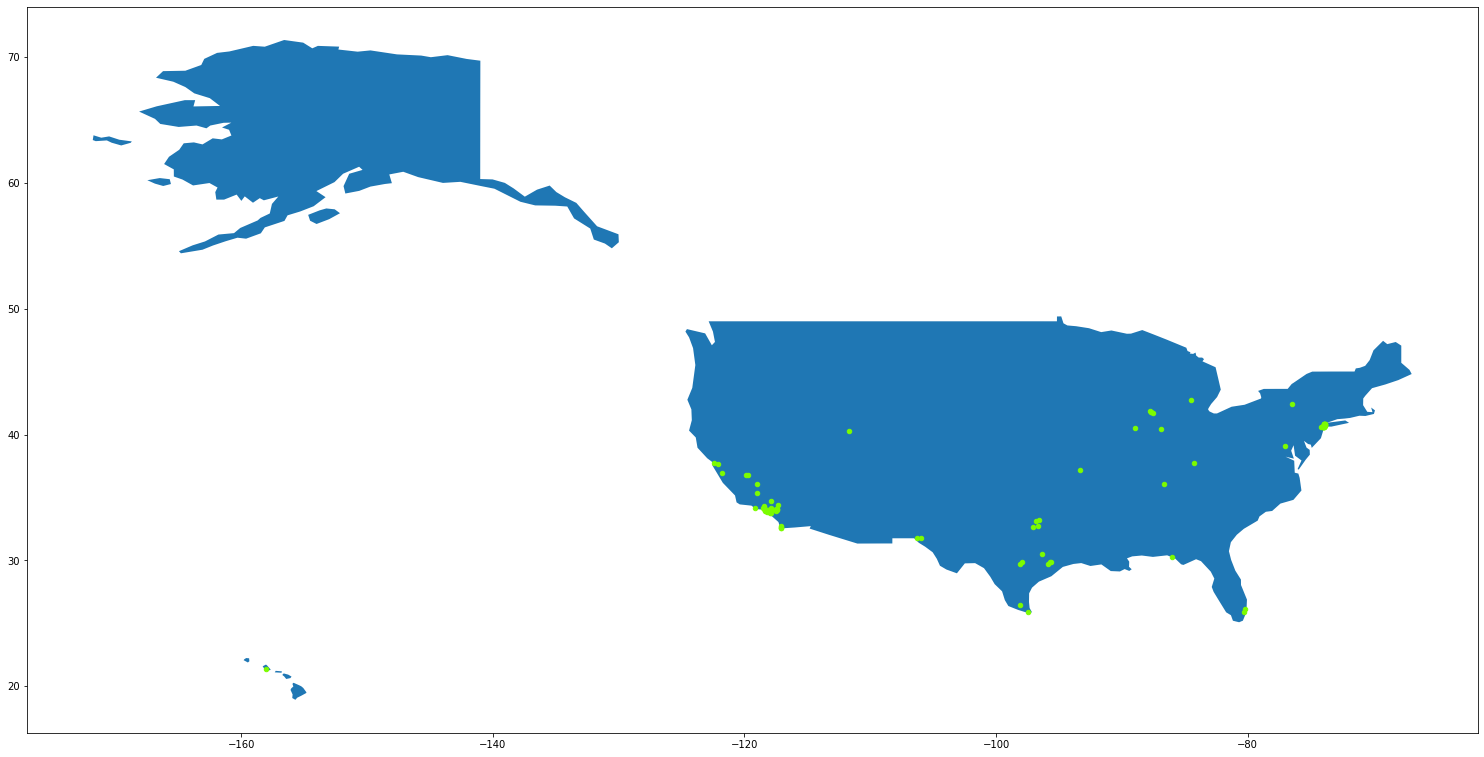

In [67]:
geometry = [Point(xy) for xy in zip(longitude, latitude)]
gdf2 = GeoDataFrame(df_locs, geometry=geometry)   

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
usa = world[world.name == "United States of America"]

gdf2.plot(ax=usa.plot(figsize=(26, 18)), marker='o', color='lawngreen', markersize=20);

# Address initial resources problem for supporting expansion plan - Graph Approach

## Get graph representation of current laboratories and candidates

### Select top 15 profit prediction as candidates

In [68]:
MAX_CANDIDATES = 15
preds = preds[:MAX_CANDIDATES]
zctas_best_profit_estimative = list(map(lambda a: a[0], preds))

### Use latitude and longitude to calculate distances between Laboratories and selected zip codes and RBF kernel to map the distance to edge weight

In [69]:
def gauss_kernel(x1, x2, sigma=90000):
    return np.exp(-((np.linalg.norm(x1-x2)**2)/(2*(sigma**2))))

def dist_latlon(latlon1, latlon2):
    lat1, lon1 = latlon1
    lat2, lon2 = latlon2
    
    try:
        x1, y1, _, _ = utm.from_latlon(lat1, lon1)
        x2, y2, _, _ = utm.from_latlon(lat2, lon2)
    except:
        return 0
    
    return gauss_kernel(np.array([x1,y1]), np.array([x2,y2]))


### Connect every candidate node to every Laboratory

In [70]:
G = nx.Graph()

colormap = []
for zcta in zctas_best_profit_estimative: # Best profit estimatives zcta
    G.add_node(zcta)
    colormap.append('lawngreen')

for zcta in list(df_geocode['zcta']): # Labs zcta
    G.add_node(zcta)
    colormap.append('r')
    
weights = []
for i, loc_preds in enumerate(locations[:MAX_CANDIDATES]):
    for j, loc_labs in enumerate(np.array(df_geocode[['latitude', 'longitude']])):
        weight = dist_latlon(loc_preds, loc_labs)
        G.add_edge(zctas_best_profit_estimative[i], int(df_geocode.iloc[j]['zcta']), weight=weight)
        weights.append(weight)

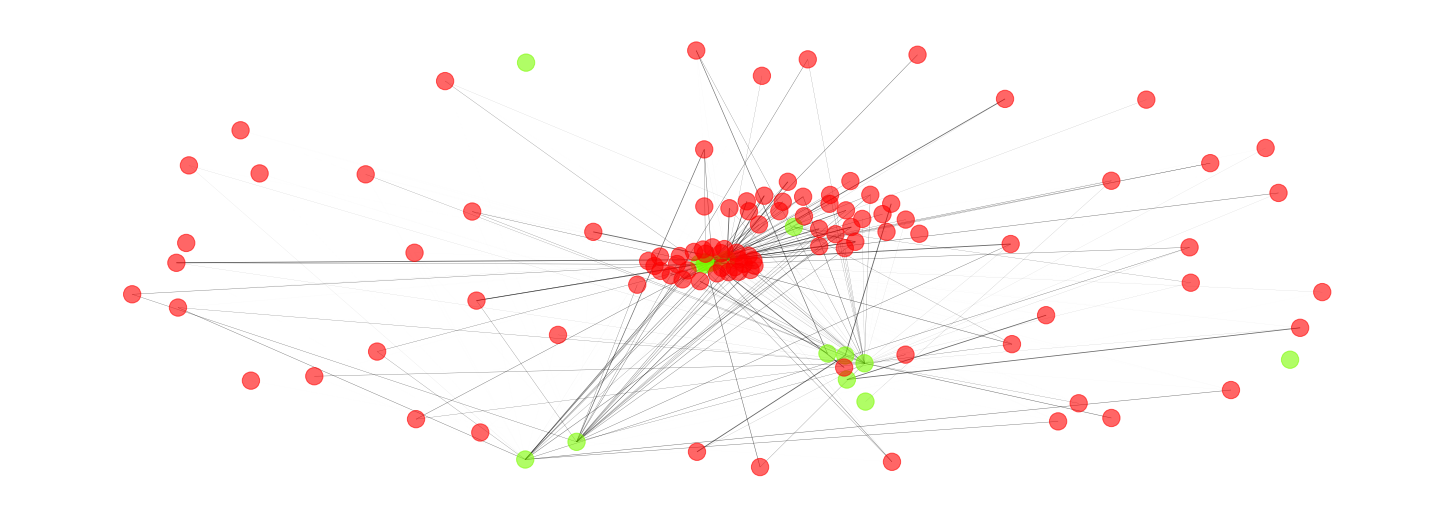

In [71]:
nx.draw(G, node_color=colormap[:len(G.nodes)], width=weights, alpha=0.6)

## Rank candidates using PageRank to find the 3 most relevant candidates nodes in the Graph representation

In [72]:
pr_nodeintimacy = nx.pagerank(G,tol=1e-5)

In [73]:
final_selection = []
for zcta in zctas_best_profit_estimative:
    final_selection.append((zcta, pr_nodeintimacy[zcta]))
final_selection = sorted(final_selection, key=lambda a: a[1], reverse=True)
final_selection = final_selection[:3]
final_selection

[(60629, 0.1183547682633911),
 (47906, 0.0684403460666902),
 (11219, 0.04584356824773351)]

# Final Selection Plot

## 60629 - Chicago, IL 
## 47906 - West Lafayette, IN
## 11219 - Brooklyn, NY

In [74]:
locations_final = []
for zcta, _ in final_selection:
    location = nomi.query_postal_code(zcta)
    lat, lon = location.latitude, location.longitude
    locations_final.append(
        (lat,lon)
    )

In [75]:
df_locs = pd.DataFrame()
latitude, longitude = [], []

for loc in locations_final:
    latitude.append(loc[0])
    longitude.append(loc[1])
    
df_locs['latitude'] = latitude
df_locs['longitude'] = longitude

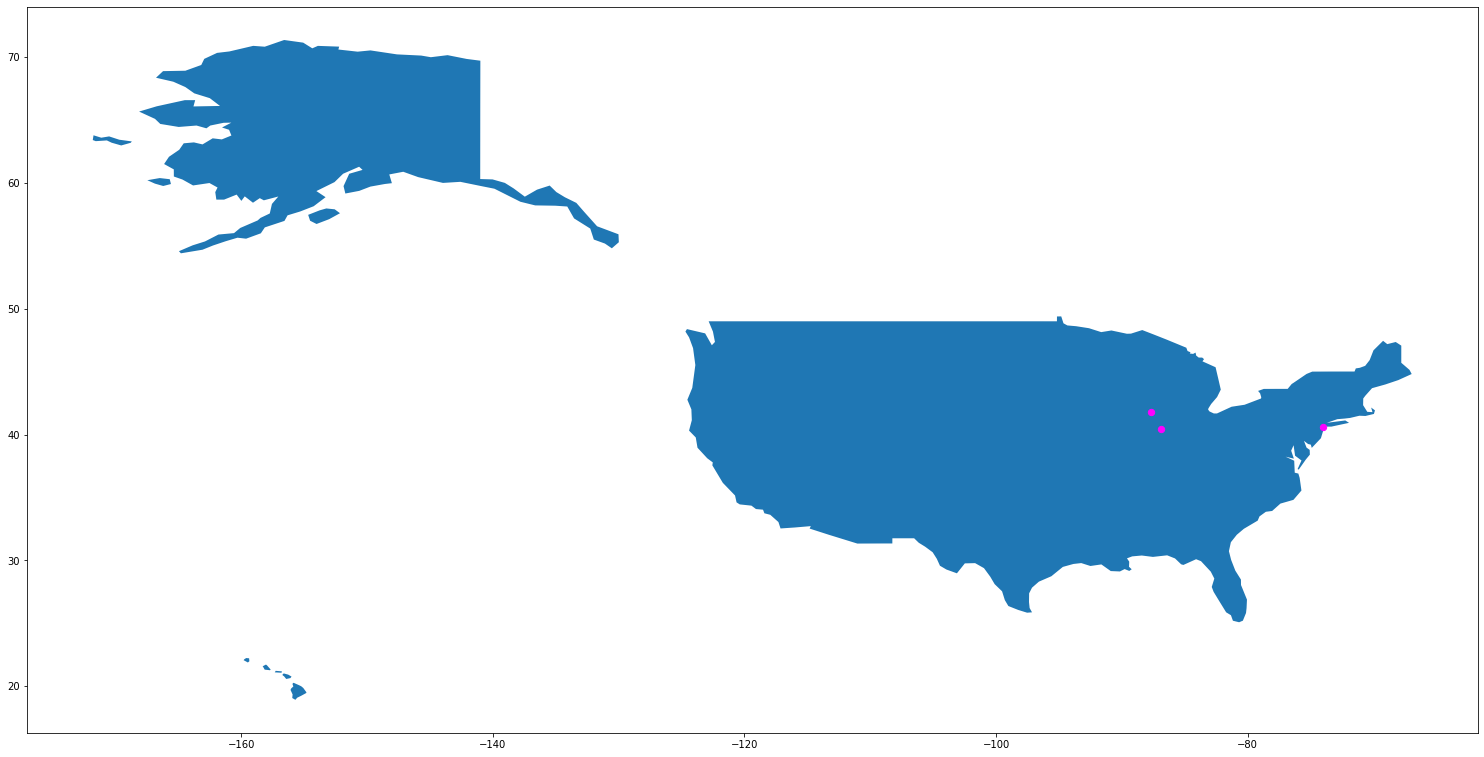

In [76]:
geometry = [Point(xy) for xy in zip(longitude, latitude)]
gdf2 = GeoDataFrame(df_locs, geometry=geometry)   

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
usa = world[world.name == "United States of America"]

gdf2.plot(ax=usa.plot(figsize=(26, 18)), marker='o', color='fuchsia', markersize=40);